In [1]:
#Python version
!python --version

Python 3.8.5


In [18]:
import numpy as np
import cv2
import os
import glob
import random
import shutil

from scipy.spatial import distance
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
mask_data = "Facemask-Dataset/Mask/Mask/" 
no_mask_data = "Facemask-Dataset/No Mask/No Mask/"

total_mask_images = os.listdir(mask_data)
print("no of mask images:: {}".format(len(total_mask_images)))
total_nonmask_images = os.listdir(no_mask_data)
print("no of non-mask images:: {}".format(len(total_nonmask_images)))

no of mask images:: 208
no of non-mask images:: 131


In [4]:
'''
os.makedirs('./train/mask')
os.makedirs('./train/no mask')
os.makedirs('./test/mask')
os.makedirs('./test/no mask')
'''

"\nos.makedirs('./train/mask')\nos.makedirs('./train/no mask')\nos.makedirs('./test/mask')\nos.makedirs('./test/no mask')\n"

In [5]:
trainNum = 100
testNum = 30

for images in random.sample(total_mask_images,trainNum):
    shutil.copy(mask_data+images, './train/mask')
for images in random.sample(total_mask_images,testNum):
    shutil.copy(mask_data+images, './test/mask')
for images in random.sample(total_nonmask_images,trainNum):
    shutil.copy(no_mask_data+images, './train/no mask')
for images in random.sample(total_nonmask_images,testNum):
    shutil.copy(no_mask_data+images, './test/no mask')

In [6]:
train_batch = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2).\
            flow_from_directory('./train', target_size=(224,224), batch_size=32, class_mode = 'categorical')
test_batch = ImageDataGenerator(
    rescale=1./255).\
            flow_from_directory('./test', target_size = (224,224), batch_size=32, class_mode='categorical')

Found 337 images belonging to 2 classes.
Found 298 images belonging to 2 classes.


In [7]:
train_batch.class_indices

{'mask': 0, 'no mask': 1}

In [8]:
class_mask = ['mask', 'no mask']

In [9]:
IMAZE_SIZE = [224,224]
vgg = VGG16(input_shape=IMAZE_SIZE+[3], weights='imagenet', include_top=False)

In [10]:
for layers in vgg.layers:
    layers.trainable = False

flatten_layer = Flatten()(vgg.output)
prediction_layer = Dense(2, activation='softmax')(flatten_layer)

model = models.Model(inputs = vgg.input, outputs = prediction_layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

In [12]:
vis = model.fit(
    train_batch,
    validation_data=test_batch,
    epochs=50,
    steps_per_epoch=len(train_batch),
    validation_steps=len(test_batch)
    )

model.save('Mask-Model.h5')

C:\Users\dhupee\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Epoch 1/50
11/11 [==============================] - 215s 19s/step - loss: 0.8591 - accuracy: 0.6499 - val_loss: 0.3107 - val_accuracy: 0.8758
Epoch 2/50
11/11 [==============================] - 221s 20s/step - loss: 0.2995 - accuracy: 0.8813 - val_loss: 0.1681 - val_accuracy: 0.9362
Epoch 3/50
11/11 [==============================] - 194s 18s/step - loss: 0.1584 - accuracy: 0.9496 - val_loss: 0.0932 - val_accuracy: 0.9698
Epoch 4/50
11/11 [==============================] - 190s 18s/step - loss: 0.1201 - accuracy: 0.9644 - val_loss: 0.0781 - val_accuracy: 0.9765
Epoch 5/50
11/11 [==============================] - 195s 18s/step - loss: 0.1028 - accuracy: 0.9674 - val_loss: 0.0888 - val_accuracy: 0.9664
Epoch 6/50
11/11 [==============================] - 218s 21s/step - loss: 0.0714 - accuracy: 0.9881 - val_loss: 0.06

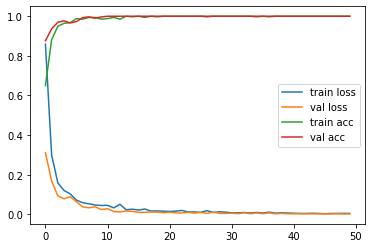

In [16]:
plt.plot(vis.history['loss'], label = 'train loss')
plt.plot(vis.history['val_loss'], label='val loss')
plt.legend()


plt.plot(vis.history['accuracy'], label = 'train acc')
plt.plot(vis.history['val_accuracy'], label='val acc')
plt.legend()

mask


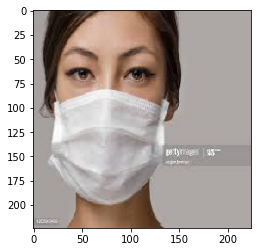

In [20]:
img = image.load_img('test\mask\Mask118.jpeg', target_size=(224,224))
x=image.img_to_array(img)
x = np.expand_dims(x,0)
y = preprocess_input(x)
pred = class_mask[np.argmax(model.predict(y))]
print(pred)
plt.imshow(img)